In [18]:
import pandas as pd

df_raw = pd.read_excel('../classes/GetData/output/Macroeconomic_Database_May25.xlsx', sheet_name='quarterly')
df_raw.set_index('date', inplace=True) # this step is super important
df_raw = df_raw[['g_ipx', 'g_pbi']]
df_raw.rename(columns={'g_ipx': 'ipx', 'g_pbi': 'gdp'}, inplace=True)
df = df_raw.loc['1997-01-01':'2019-12-01']
df.head()

,ipx,gdp
date,,
1997-03-01,0.672680,5.179629
1997-06-01,0.394339,8.230561
1997-09-01,8.866004,6.404664
1997-12-01,-1.280914,5.981782
1998-03-01,-6.438255,2.227753


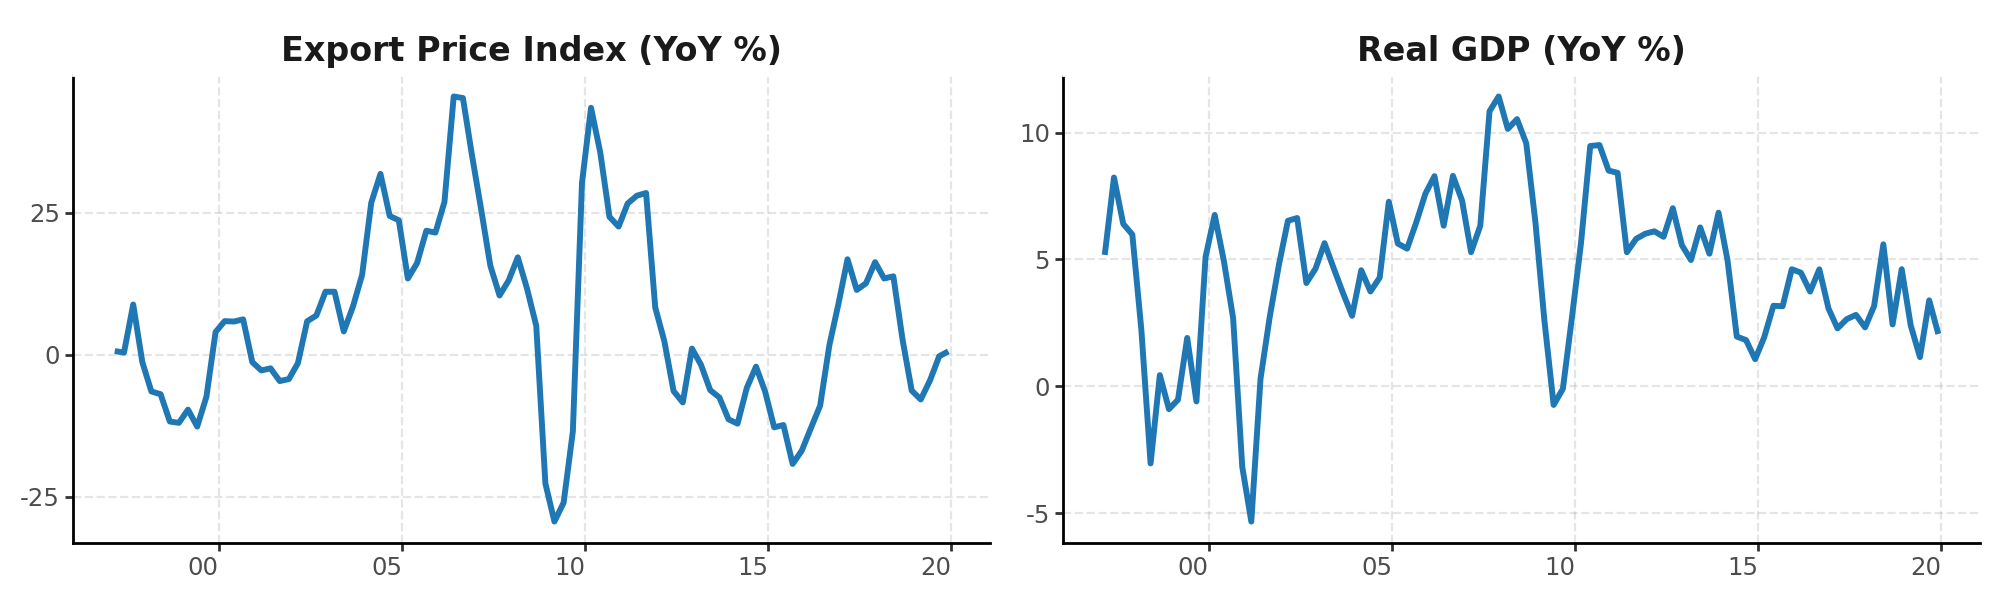

In [19]:
from MacroPy import generate_series_plot

full_names = ["Export Price Index (YoY %)", "Real GDP (YoY %)"]
generate_series_plot(df, series_titles=full_names)

In [20]:
from MacroPy import ClassicVAR

cvar = ClassicVAR(df, lags=4)
cvar.model_summary()


**MacroPy Toolbox for Macroeconometric Analysis in Python**  
Developed by [Renato Vassallo](https://www.linkedin.com/in/renatovassallo), Institute for Economic Analysis (IAE-CSIC)  
Version 0.1.2, May 2025  

---

**Model Specifications**  
- **Model Type**: Classic VAR  
- **Endogenous Variables**: ipx, gdp  
- **Exogenous Variables**: Constant   
- **Number of Lags**: 4  
- **Total Number of Coefficients to Estimate**: 18  

---

**Forecast & IRF Details**  
- **Impulse Response Horizon**: 20  
- **Forecast Horizon**: 12  
- **IRF Computation**: 1 Standard Deviation  

---

**VAR Model Equations**

$$
\begin{align*}
ipx_{t} &= b_{1,1}^{1} ipx_{t-1} + b_{1,2}^{1} gdp_{t-1} + b_{1,1}^{2} ipx_{t-2} + b_{1,2}^{2} gdp_{t-2} + b_{1,1}^{3} ipx_{t-3} + b_{1,2}^{3} gdp_{t-3} + b_{1,1}^{4} ipx_{t-4} + b_{1,2}^{4} gdp_{t-4} + c_{1} + e_{t}^{ipx} \\
gdp_{t} &= b_{2,1}^{1} ipx_{t-1} + b_{2,2}^{1} gdp_{t-1} + b_{2,1}^{2} ipx_{t-2} + b_{2,2}^{2} gdp_{t-2} + b_{2,1}^{3} ipx_{t-3} + b_{2,2}^{3} gdp_{t-3} + b_{2,1}^{4} ipx_{t-4} + b_{2,2}^{4} gdp_{t-4} + c_{2} + e_{t}^{gdp} \\
\end{align*}
$$


Monte Carlo IRFs: 100%|██████████| 1000/1000 [00:00<00:00, 3447.57it/s]


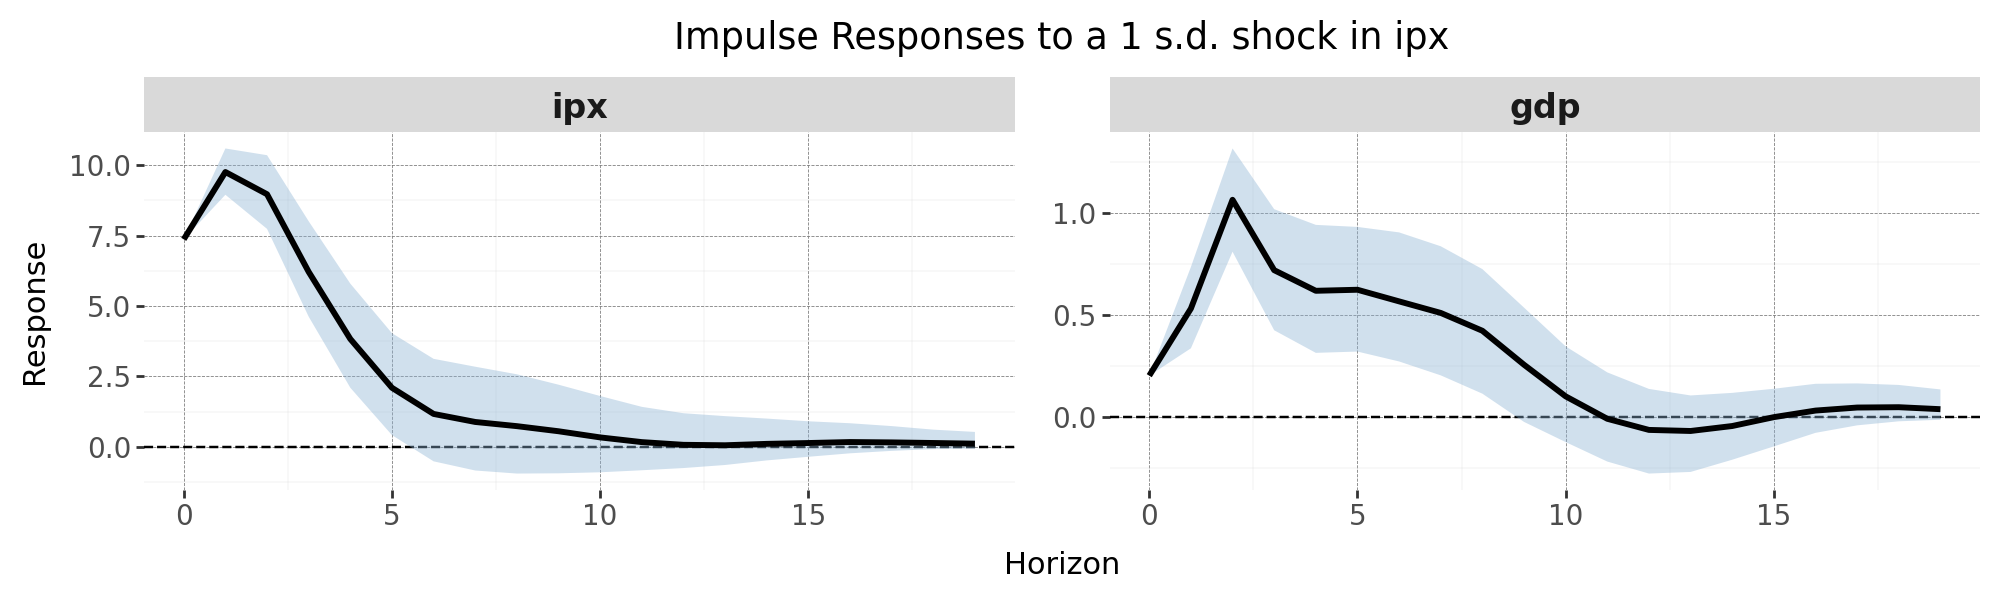

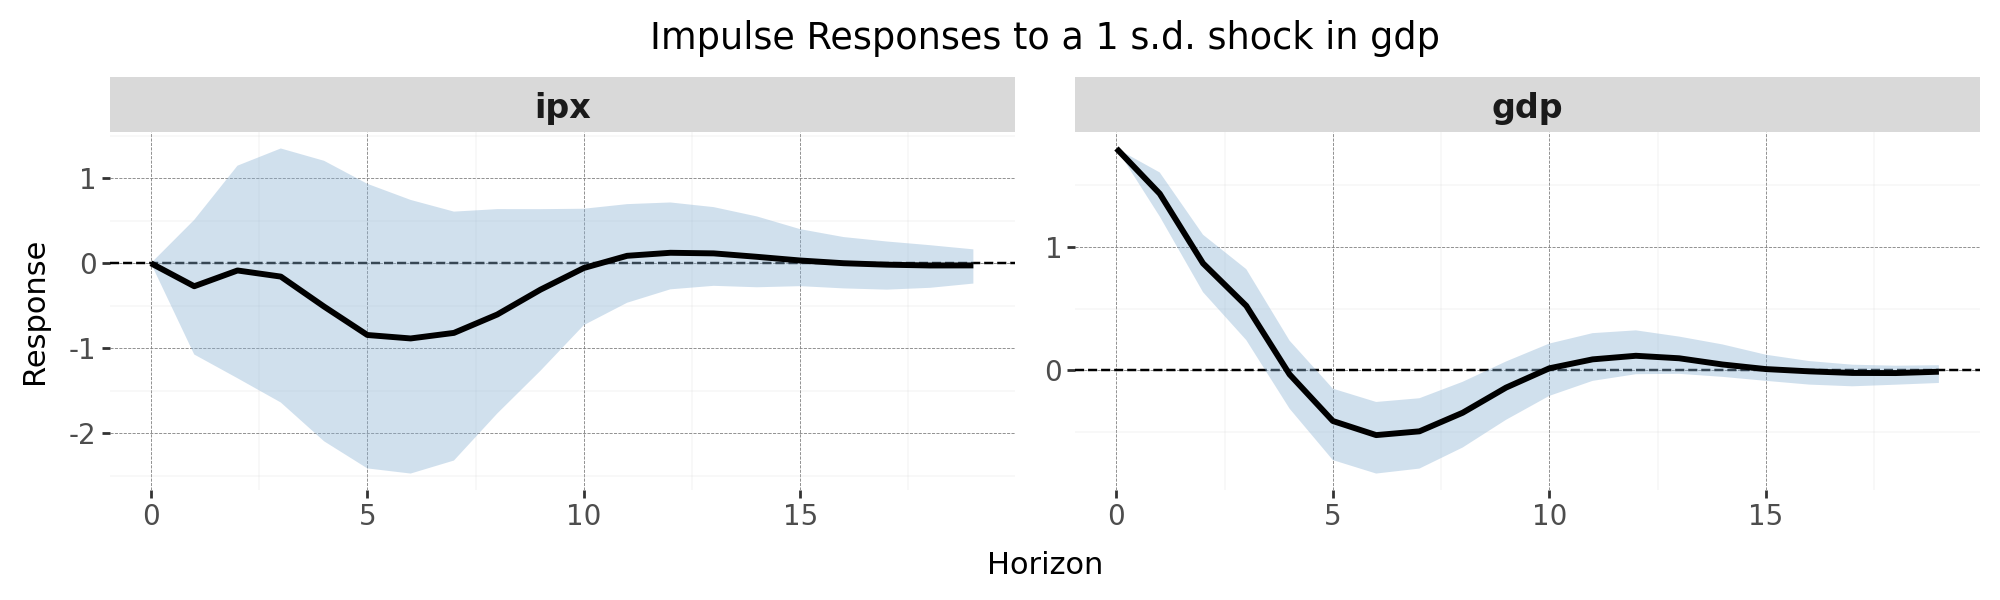

In [21]:
svar_irfs = cvar.compute_irfs(plot_irfs=True)

## Local Projections

In [22]:
P = 4  # number of lags
y_col = 'gdp'
x_col = 'ipx'

# Step 1: Contemporaneous control for gdp (ordered before the shock)
contemporaneous = df[['gdp']].copy()  # only gdp

# Step 2: Add lags of all system variables (gdp, ipx, tax)
lags = []
for lag in range(1, P + 1):
    lagged = df.shift(lag).copy()
    lagged.columns = [f"{col}_lag{lag}" for col in df.columns]
    lags.append(lagged)

# Step 3: Combine controls
controls = pd.concat([contemporaneous] + lags, axis=1)

# Step 4: Drop NaNs and align
controls_clean = controls.dropna()
y_clean = df[y_col].loc[controls_clean.index]
x_clean = df[x_col].loc[controls_clean.index]

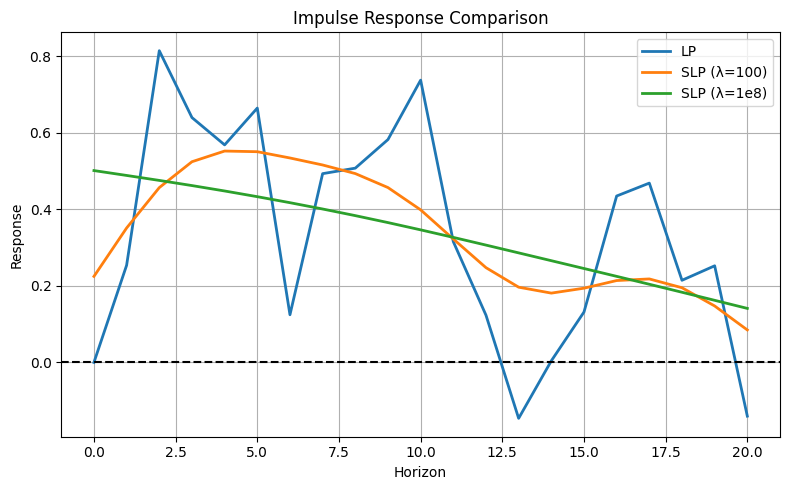

In [23]:
from MacroPy import SmoothLocalProjections as SLP

slp_model = SLP(response=y_clean, shock=x_clean, controls=controls_clean, lags=4, horizons=list(range(0, 21)))

res1 = slp_model.estimate('reg')
res2 = slp_model.estimate('smooth', penalty_lambda=50000)
res3 = slp_model.estimate('smooth', penalty_lambda=1e7)

SLP.plot_irfs([res1, res2, res3], labels=["LP", "SLP (λ=100)", "SLP (λ=1e8)"])

In [24]:
# Use the average across simulations for SVAR IRFs
svar_irfs_mean = svar_irfs.mean(axis=0)  # shape: (20, 2, 2)
svar_irf = svar_irfs_mean[:, 1, 0]  # shape: (20,)
lp_irf = res1["IR"]

print("SVAR IRFs shape:", svar_irf.shape)
print("LP IR shape:", lp_irf.shape)

SVAR IRFs shape: (20,)
LP IR shape: (21,)


In [26]:
svar_irf

array([ 0.20383402,  0.53166502,  1.06418948,  0.731334  ,  0.62667164,
        0.62991924,  0.58717199,  0.52354802,  0.42751148,  0.26818522,
        0.11368192, -0.0035004 , -0.06538902, -0.07335536, -0.04161904,
        0.00345883,  0.04360369,  0.06773859,  0.07376749,  0.06473487])

In [27]:
lp_irf

array([-1.29317332e-13,  2.53699520e-01,  8.14009425e-01,  6.39438818e-01,
        5.68079860e-01,  6.64227257e-01,  1.24468773e-01,  4.92951070e-01,
        5.07328169e-01,  5.82032910e-01,  7.37161749e-01,  3.15367487e-01,
        1.23376322e-01, -1.46045273e-01,  4.14663946e-03,  1.31606420e-01,
        4.34550837e-01,  4.68284214e-01,  2.14483727e-01,  2.52305980e-01,
       -1.40310822e-01])

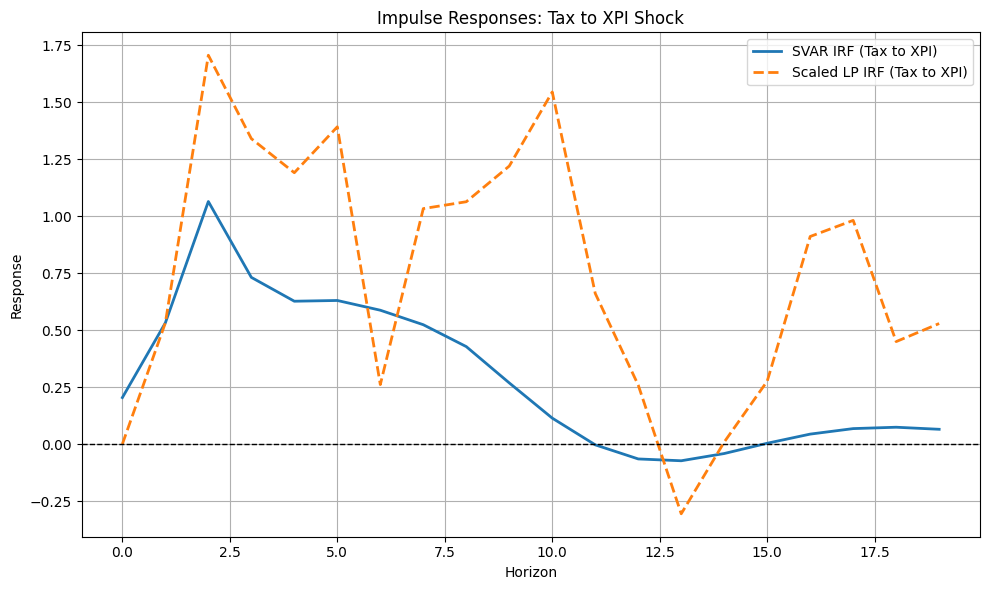

In [25]:
import numpy as np
import matplotlib.pyplot as plt

scaling_factor = svar_irf[1] / lp_irf[1]  # skip IR[0] since LP starts at h=1

lp_ir_scaled = lp_irf[:len(svar_irf)] * scaling_factor
horizons = np.arange(len(lp_ir_scaled))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(horizons, svar_irf, label='SVAR IRF (Tax to XPI)', linewidth=2)
plt.plot(horizons, lp_ir_scaled, '--', label='Scaled LP IRF (Tax to XPI)', linewidth=2)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title("Impulse Responses: Tax to XPI Shock")
plt.xlabel("Horizon")
plt.ylabel("Response")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()